# Credits

* **Author** : Aurelio Murolo ;
* **Date** : March, 2025 ;
* **Git-Hub** : [University Project Repository](https://github.com/AurelioMurolo/University-Projects) .

# Modules Import & Agnostic Device Setting

In [ ]:
# Must
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import os
from sklearn.model_selection import train_test_split
from scipy import stats
from google.colab import files
from google.colab import output

# Model
import torch
from torch import nn
import torch.nn.functional as F
import torchaudio
from torchaudio import transforms as T
import torchaudio.functional as f
from torch.utils.data import DataLoader
from torch.utils.data import Dataset


!pip install -q torchinfo
from torchinfo import summary
!pip install -q torchmetrics
from torchmetrics.classification import Accuracy

# UrbanSound dataset & Audio tools
!pip install --upgrade soundata
!pip install -q soundata"[plots]"
!pip install librosa
from IPython.display import Audio
import librosa
import soundata

# Control Bar
!pip install -q tqdm
from tqdm.auto import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.7/931.7 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 844.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done

In [ ]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print("The available device is: ", device)

The available device is:  cpu


# Code Reproducibility

In according to the official documentation about [Reproducibility](https://pytorch.org/docs/stable/notes/randomness.html):

> As long as `torch.manual_seed()` is set to a constant at the beginning of an application and all **other sources of nondeterminism** have been eliminated, the same series of random numbers will be generated each time the application is run in the same environment.

The other sources of nondeterminism include both the seeds of other libraries and the intrinsical randomness of the algorithms used by Pytorch for its operations.

Although a good reproducibility may cause a decrese both in performances and speed, it gurantees the optimal condition for the experimentations, Galileo Galilei *docet* . In order to decrees the non - deterministic behaviour we can run the following line of code.





In [ ]:
seed = 42

# Torch
torch.manual_seed(seed)  # Seed for both CPU and GPU
torch.cuda.manual_seed(seed)  # Seed for GPU random number generation
torch.cuda.manual_seed_all(seed)  # For multi-GPU

torch.backends.cudnn.benchmark = False  # Deterministically select an algorithm if True
torch.backends.cudnn.deterministic = False # if True, only nondeterministic algorithms are available they will throw a RuntimeError when called
torch.Generator().manual_seed(seed)  # Seed for batch shuffling

# Numpy
np.random.seed(seed)

# Python
random.seed(seed)

You can find the full list of the normally-nondeterministic operations that will act deterministically when `torch.backends.cudnn.deterministic = True` at the following [link](https://pytorch.org/docs/stable/generated/torch.use_deterministic_algorithms.html#torch.use_deterministic_algorithms) .

In the end it's important to underline that it sufficient to call all the above functions only once at the beginning of the script, especially on a Jupyter Notebook like this where sometimes there are some "mis-comunication" among the cell of code. Anyway as you will se i still called them toI do it to avoid any possible problems.

# Urban Sound Dataset Import

In [ ]:
#rm -rf /root/sound_datasets/urbansound8k

In [ ]:
# DataSet Download & Validation
dataset = soundata.initialize('urbansound8k')
dataset.download()
dataset.validate()

AttributeError: `np.float_` was removed in the NumPy 2.0 release. Use `np.float64` instead.

In [ ]:

ids = dataset.clip_ids        # the list of urbansound8k's clip ids
clips = dataset.load_clips()  # Load all clips in the dataset
first_clip = clips[ids[0]]    # Get the first clip

# Accessing a random clip's tags annotation
example_clip = dataset.choice_clip()
example_tags = example_clip.tags
wave_form, sample_rate = example_clip.audio
print('Tags: ', example_tags)
print('Label, id: ', example_clip.class_label,', ',example_clip.class_id)
print('Wave Form Shape: ' , wave_form.shape)
print('Sample Rate: ', sample_rate, 'Hz')

Tags:  Tags(confidence, labels, labels_unit)
Label, id:  dog_bark ,  3
Wave Form Shape:  (176400,)
Sample Rate:  44100 Hz


In [ ]:
n_clips = len(ids)
print(f"The dataset contains {n_clips} clips.")

The dataset contains 8732 clips.


In [ ]:
sampling_interval = 1/sample_rate
print(f"The sampling interval is: {round(sampling_interval, 6)} seconds ---> 23 ns.")

The sampling interval is: 2.3e-05 seconds ---> 23 ns.


In [ ]:
# Ensure that all the clips have the same sample rate & that the audio is mono-channel
length_list = []
for key, clip in dataset.load_clips().items():
  wave_form , sample_rate = clip.audio
  length_list.append(len(wave_form))
  assert sample_rate == 44100
  assert len(wave_form.shape) == 1

print('All clips have the same sample rate.')
print('All clips are mono-channel.')

All clips have the same sample rate.
All clips are mono-channel.


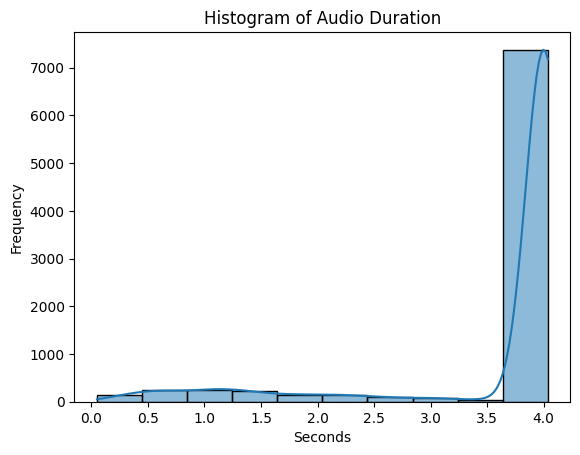

In [ ]:
lenght_array = np.array(length_list)
mean_lenght = np.mean(lenght_array)
median_lenght = np.median(lenght_array)
mode_lenght = stats.mode(lenght_array)[0]
std_lenght = np.std(lenght_array)
max_lenght = np.max(lenght_array)
min_lenght = np.min(lenght_array)

# Create the histogram
sns.histplot(lenght_array / sample_rate, bins = 10, kde = True)

plt.xlabel("Seconds")
plt.ylabel("Frequency")
plt.title("Histogram of Audio Duration")
plt.show()

In [ ]:
print('Mean: ', round(mean_lenght, 0))
print('Median: ', median_lenght)
print('Mode: ', mode_lenght)
print('Standard Deviation: ', round(std_lenght, 0))
print('Max: ', round(max_lenght, 0))
print('Min: ', min_lenght)

Mean:  159092.0
Median:  176400.0
Mode:  176400
Standard Deviation:  42968.0
Max:  178017
Min:  2205


Since the waveforms may have different durations, we will apply two different transformation on the waveforms in order to estabilsh a unique format in the temporal domain. First of all one have to choose the target size of the waveforms duration, in our specific case, based on the distribution plotted above and its statistical indicators, it might be a good idea to set the median value as our target size. At this point there are only two possibile scenarios:
1. `if len(wave_form) <= target_size` $\to$ **Padding** transformation;
2. `if len(wave_form) >= target_size` $\to$ **Cutting** transformation.

I'm going to solve this problem in the Audio Pre-processing section.

In [ ]:
# Iterate over the dataset
for i, (key, clip) in enumerate(dataset.load_clips().items()):
    if i <= 3 :
      print(f' key: {key} | clip audio path: {clip.audio_path}')

 key: 135776-2-0-49 | clip audio path: /root/sound_datasets/urbansound8k/audio/fold1/135776-2-0-49.wav
 key: 46654-6-0-0 | clip audio path: /root/sound_datasets/urbansound8k/audio/fold1/46654-6-0-0.wav
 key: 57320-0-0-24 | clip audio path: /root/sound_datasets/urbansound8k/audio/fold1/57320-0-0-24.wav
 key: 134717-0-0-26 | clip audio path: /root/sound_datasets/urbansound8k/audio/fold1/134717-0-0-26.wav


## DataSet Exploration

The `Statistics(Computational)` option is very time consuming.

In [ ]:
output.enable_custom_widget_manager()

In [ ]:
dataset.explore_dataset(example_clip)

In [ ]:
output.disable_custom_widget_manager()

## Audio Pre-processing

In [ ]:
target_size = int(median_lenght)

# Cutting Function
def cut_if_necessary(signal, target_size):
  if signal.shape[0] > target_size:
    cutted_signal = signal[:, :target_size]

  return cutted_signal

# Padding Function
def right_pad_if_necessary(signal, target_size):
  lenght = signal.shape[0]
  if lenght < target_size:
    num_missing_samples = target_size - lenght
    last_dim_padding = (0, num_missing_samples)

    # last_dim_padding[0]: 0 -> number of elements to add on the left
    # last_dim_padding[1]: num_missing_samples -> number of elements to add on the right

    padded_signal = F.pad(signal, last_dim_padding, value = 0.)

  return padded_signal

Lets' test our function with some audio data:

In [ ]:
random_audio_number = 10
for i in range(random_audio_number + 1):
  print(f'Random Audio number: {i}')
  wave_form , sample_rate = dataset.choice_clip().audio
  wave_form = torch.Tensor(wave_form)
  print(f"Shape of wave_form: {wave_form.shape}")

  if wave_form.shape[0] > target_size:
    cutted_signal = cut_if_necessary(wave_form, target_size)
    print(f'The signal has been cutted')
    print(f"Shape of cutted_signal: {cutted_signal.shape}\n")

  elif wave_form.shape[0] == target_size:
    print(f'The signal has not been transformed\n')

  else:
    padded_signal = right_pad_if_necessary(wave_form, target_size)
    print(f'The signal has been padded')
    print(f"Shape of padded_signal: {padded_signal.shape}\n")

Random Audio number: 0
Shape of wave_form: torch.Size([176400])
The signal has not been transformed

Random Audio number: 1
Shape of wave_form: torch.Size([176400])
The signal has not been transformed

Random Audio number: 2
Shape of wave_form: torch.Size([176400])
The signal has not been transformed

Random Audio number: 3
Shape of wave_form: torch.Size([176400])
The signal has not been transformed

Random Audio number: 4
Shape of wave_form: torch.Size([176400])
The signal has not been transformed

Random Audio number: 5
Shape of wave_form: torch.Size([176400])
The signal has not been transformed

Random Audio number: 6
Shape of wave_form: torch.Size([176400])
The signal has not been transformed

Random Audio number: 7
Shape of wave_form: torch.Size([176400])
The signal has not been transformed

Random Audio number: 8
Shape of wave_form: torch.Size([176400])
The signal has not been transformed

Random Audio number: 9
Shape of wave_form: torch.Size([176400])
The signal has not been tra

In according to the distribution of the signals duration, the padding transformation will occur many more times than cutting, half of the dataset respect the condition:  `wave_form.shape[0] < target_size` .

Now we have to

##Waveform Visualization

In [ ]:
N_FFT = 1024
N_MELS = 64
sample_rate = 44100

In [ ]:
ids = dataset.clip_ids        # the list of urbansound8k's clip ids
clips = dataset.load_clips()  # Load all clips in the dataset
first_clip = clips[ids[0]]    # Get the first clip

# Accessing a random clip's tags annotation
example_clip = dataset.choice_clip()
example_tags = example_clip.tags
wave_form, sample_rate = example_clip.audio
print('Tags: ', example_tags)
print('Label, id: ', example_clip.class_label,', ',example_clip.class_id)
print('Wave Form Shape: ' , wave_form.shape)
print('Duration(sec): ', round(len(wave_form) / sample_rate, 2))
print('Sample Rate: ', sample_rate, 'Hz')

Tags:  Tags(confidence, labels, labels_unit)
Label, id:  siren ,  8
Wave Form Shape:  (26460,)
Duration(sec):  0.6
Sample Rate:  44100 Hz


In [ ]:
wave_form = torch.Tensor(wave_form)

In [ ]:
def plot_waveform(waveform : torch.Tensor, sr, title = "Waveform", ax = None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)

    plt.tight_layout()
    plt.show()


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

    plt.tight_layout()
    plt.show()


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")

    plt.tight_layout()
    plt.show()

In [ ]:
if len(wave_form.shape) == 1:
  wave_form = wave_form.unsqueeze(0)

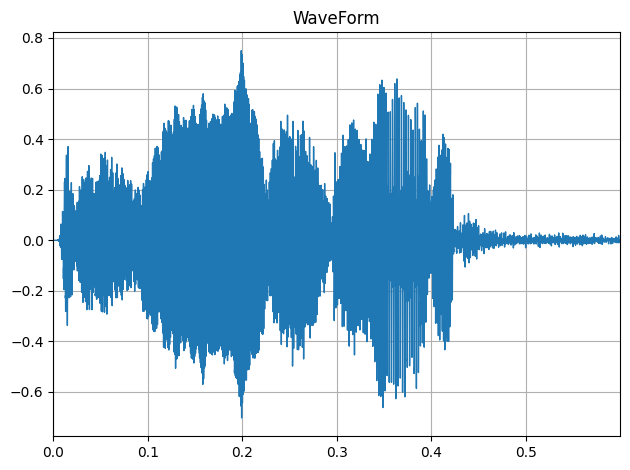

In [ ]:
plot_waveform(wave_form, sr = sample_rate, title = 'WaveForm')

### Waveform Spectograms

In [ ]:
spectogram_transform = T.Spectrogram(n_fft = N_FFT)
spectogram = spectogram_transform(wave_form)

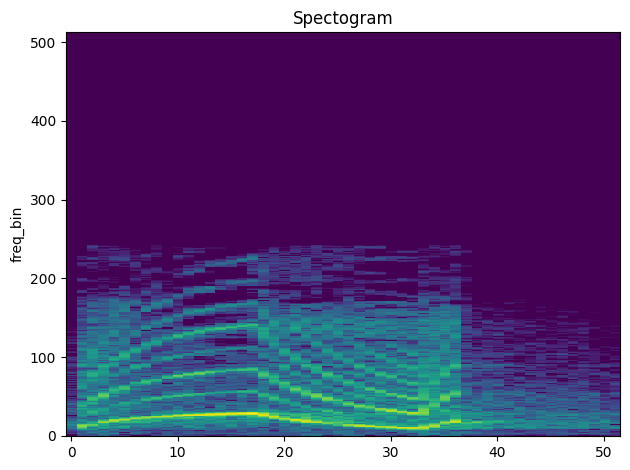

In [ ]:
plot_spectrogram(spectogram.squeeze(), title = 'Spectogram')

### Waveform Mel Spectograms

In [ ]:
Mel_spectogram_transform = T.MelSpectrogram(sample_rate = sample_rate, n_fft = N_FFT, hop_length = 128, n_mels = N_MELS)
Mel_spectogram = Mel_spectogram_transform(wave_form)

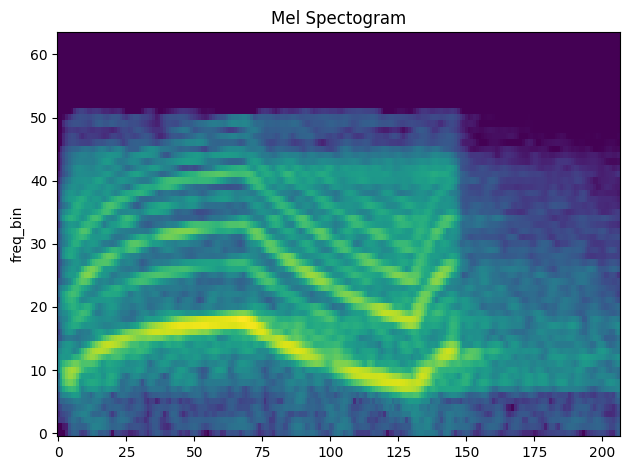

In [ ]:
plot_spectrogram(Mel_spectogram.squeeze(), title = 'Mel Spectogram' )

### Waveform Mel filter-bank

In [ ]:
n_fft = N_FFT
n_mels = N_MELS

mel_filters = f.melscale_fbanks(int(n_fft // 2 + 1),
                                n_mels = n_mels,
                                f_min = 0.0,
                                f_max = sample_rate / 2.0,
                                sample_rate = sample_rate,
                                norm = "slaney")

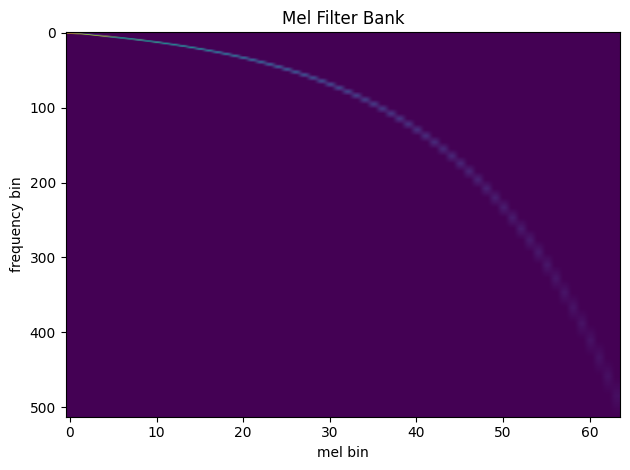

In [ ]:
plot_fbank(mel_filters, title = "Mel Filter Bank")

### Waveform Audio Reproduction

In [ ]:
print('Label: ', example_clip.class_label)

Label:  siren


In [ ]:
Audio(wave_form.numpy(), rate = sample_rate)

# UrbanSet Dataset Class

In [ ]:
class UrbanSoundDataset(Dataset):
    def __init__(self, annotations_file, audio_dir, transformation, target_sample_rate, num_samples,device):
        self.annotations = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir
        self.device = device
        self.transformation = transformation.to(self.device)
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples

    def __len__(self):
        return len(self.annotations)


    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        label = torch.tensor(self._get_audio_sample_label(index), dtype=torch.long).to(self.device)
        signal, sr = torchaudio.load(audio_sample_path)

        # Pre-processing
        signal = signal.to(self.device)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)

        # Mel-transformation
        mel_signal = self.transformation(signal)

        return signal, label, mel_signal

    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]

        return signal

    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)

        return signal

    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate).to(self.device)
            signal = resampler(signal)

        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)

        return signal

    def _get_audio_sample_path(self, index):
        fold = f"fold{self.annotations.iloc[index, 5]}"
        path = os.path.join(self.audio_dir, fold, self.annotations.iloc[index, 0])

        return path

    def _get_audio_sample_label(self, index):
        return self.annotations.iloc[index, 6]

In [ ]:
class UrbanSoundDataset_Train_Val(UrbanSoundDataset):

  def __init__(self, annotations_file, audio_dir, transformation, target_sample_rate, num_samples, device,
               val_size=0.2, random_state=seed, split="train"):
      super().__init__(annotations_file, audio_dir, transformation, target_sample_rate, num_samples, device)

      self.annotations = pd.read_csv(annotations_file)

      # Train-Validation
      self.annotations_train, self.annotations_val = train_test_split(self.annotations,
                                                                      test_size=val_size,
                                                                      random_state=random_state)

      # Split
      if split == "train":
          self.annotations = self.annotations_train

      elif split == "val":
          self.annotations = self.annotations_val

      else:
          raise ValueError("split must be 'train' or 'val'")

  def __len__(self):
      return len(self.annotations)

  def __getitem__(self, index):
      return super().__getitem__(index)  # Usa la logica della classe base

In [ ]:
print("Dataset root directory:", dataset.data_home)

Dataset root directory: /root/sound_datasets/urbansound8k


In [ ]:
DATASET_PATH = dataset.data_home

print("Dataset folder exists:", os.path.exists(DATASET_PATH))
print("Metadata folder exists:", os.path.exists(os.path.join(DATASET_PATH, "metadata")))
print("Audio folder exists:", os.path.exists(os.path.join(DATASET_PATH, "audio")))

# List files to confirm
if os.path.exists(DATASET_PATH):
    print("Files in dataset:", os.listdir(DATASET_PATH))

Dataset folder exists: True
Metadata folder exists: True
Audio folder exists: True
Files in dataset: ['audio', 'metadata', 'FREESOUNDCREDITS.txt', 'UrbanSound8K_README.txt', 'UrbanSound8K.tar.gz']


In [ ]:
ANNOTATIONS_FILE = "/root/sound_datasets/urbansound8k/metadata/UrbanSound8K.csv"
AUDIO_DIR = "/root/sound_datasets/urbansound8k/audio"
SAMPLE_RATE = 41000
NUM_SAMPLES = 41000

mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate = SAMPLE_RATE,
                                                       n_fft = 1024,
                                                       hop_length = 512,
                                                       n_mels = 64)


usd = UrbanSoundDataset(ANNOTAT\IONS_FILE,
                        AUDIO_DIR,
                        mel_spectrogram,
                        SAMPLE_RATE,
                        NUM_SAMPLES,
                        device)

print(f"There are {len(usd)} samples in the dataset.")
signal, label = usd[1]
channels = signal.shape[0]
n_mels = signal.shape[1]
time = signal.shape[2]

print(f"Signal shape: {signal.shape}")
print(f"Label: {label}")
print(f"Number of channels: {channels}")
print(f"Number of mels: {n_mels}")
print(f"Time: {time}")

There are 8732 samples in the dataset.
Signal shape: torch.Size([1, 64, 81])
Label: 2
Number of channels: 1
Number of mels: 64
Time: 81


In [ ]:
usd_train = UrbanSoundDataset_Train_Val(ANNOTATIONS_FILE,
                                         AUDIO_DIR,
                                         mel_spectrogram,
                                         SAMPLE_RATE,
                                         NUM_SAMPLES,
                                         device,
                                         split = "train")

usd_val = UrbanSoundDataset_Train_Val(ANNOTATIONS_FILE,
                                       AUDIO_DIR,
                                       mel_spectrogram,
                                       SAMPLE_RATE,
                                       NUM_SAMPLES,
                                       device,
                                       split = "val")

In [ ]:
# DataLoader
BATCH_SIZE = 256
usd_dataloader = DataLoader(usd, batch_size = BATCH_SIZE, shuffle = True)

usd_train_dataloader = DataLoader(usd_train, batch_size = BATCH_SIZE, shuffle = True)
usd_val_dataloader = DataLoader(usd_val, batch_size = BATCH_SIZE, shuffle = True)

In [ ]:
len(usd_train_dataloader), len(usd_val_dataloader)

(28, 7)

# Sound Classificator

In [ ]:
def plot_training_results(epochs, train_losses, val_losses, train_accuracies, val_accuracies):
    """
    Plots the training loss, validation loss, training accuracy, and validation accuracy trends.

    Parameters:
    epochs (int): Number of epochs
    train_losses (list): List of training loss values
    val_losses (list): List of validation loss values
    train_accuracies (list): List of training accuracy values
    val_accuracies (list): List of validation accuracy values
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Loss plot
    axes[0].plot(range(epochs), train_losses, label='Train Loss', color='blue')
    axes[0].plot(range(epochs), val_losses, label='Val Loss', color='red')
    axes[0].set_title('Loss Trend')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Accuracy plot
    axes[1].plot(range(epochs), train_accuracies, label='Train Accuracy', color='blue')
    axes[1].plot(range(epochs), val_accuracies, label='Val Accuracy', color='red')
    axes[1].set_title('Accuracy Trend')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

## CNN Architecture for Mels

In [ ]:
class ConvNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional Layers
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=1,
                                              out_channels=16,
                                              kernel_size=3,
                                              stride=1,
                                              padding=2),
                                              nn.ReLU(),
                                              nn.MaxPool2d(kernel_size=2))

        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=16,
                                              out_channels=32,
                                              kernel_size=3,
                                              stride=1,
                                              padding=2),
                                              nn.ReLU(),
                                              nn.MaxPool2d(kernel_size=2))

        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=32,
                                              out_channels=64,
                                              kernel_size=3,
                                              stride=1,
                                              padding=2),
                                              nn.ReLU(),
                                              nn.MaxPool2d(kernel_size=2))

        self.conv4 = nn.Sequential(nn.Conv2d(in_channels=64,
                                              out_channels=128,
                                              kernel_size=3,
                                              stride=1,
                                              padding=2),
                                              nn.ReLU(),
                                              nn.MaxPool2d(kernel_size=2))
        # Fully connected Layers
        self.flatten = nn.Flatten(start_dim = 1, end_dim = -1)
        self.linear = nn.Linear(128 * 5 * 6, 10)

    def forward(self, input_data):
        # input data shape : batch_size x channel x n_mels x time

        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = self.flatten(x)

        logits = self.linear(x)

        return logits

In [ ]:
loss_fn = nn.CrossEntropyLoss().to(device)
accuracy_fn = Accuracy(task = "multiclass", num_classes = 10).to(device)

## CNN Architecture for Waveform

In [ ]:
class ConvNetwork_1D(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional Layers
        self.conv1 = nn.Sequential(nn.Conv1d(in_channels=1,
                                              out_channels=16,
                                              kernel_size=3,
                                              stride=1,
                                              padding=2),
                                              nn.ReLU(),
                                              nn.MaxPool1d(kernel_size=2)) # Fallo in modo tale da prendere n intervalli di campionamento

        self.conv2 = nn.Sequential(nn.Conv1d(in_channels=16,
                                              out_channels=32,
                                              kernel_size=3,
                                              stride=1,
                                              padding=2),
                                              nn.ReLU(),
                                              nn.MaxPool1d(kernel_size=2))


        # Fully connected Layers
        self.flatten = nn.Flatten(start_dim = 1, end_dim = -1)
        self.linear = nn.Linear(128 * 5 * 6, 10)

    def forward(self, input_data):
        # input data shape : batch_size x channel x n_mels x time

        x = self.conv1(input_data)
        x = self.conv2(x)

        x = self.flatten(x)
        print(x.shape) # e poi aggiusti dopo, forse non ti serve proprio
        logits = self.linear(x)

        return logits

## Model Summary

In [ ]:
summary_model = summary(ConvNetwork(),
                        input_size =  (BATCH_SIZE, channels, n_mels, time),
                        col_names = ["input_size", "output_size", "num_params"],
                        col_width = 20,
                        depth = 3,
                        row_settings = ["var_names"],
                        verbose = 1)

Layer (type (var_name))                  Input Shape          Output Shape         Param #
ConvNetwork (ConvNetwork)                [256, 1, 64, 81]     [256, 10]            --
├─Sequential (conv1)                     [256, 1, 64, 81]     [256, 16, 33, 41]    --
│    └─Conv2d (0)                        [256, 1, 64, 81]     [256, 16, 66, 83]    160
│    └─ReLU (1)                          [256, 16, 66, 83]    [256, 16, 66, 83]    --
│    └─MaxPool2d (2)                     [256, 16, 66, 83]    [256, 16, 33, 41]    --
├─Sequential (conv2)                     [256, 16, 33, 41]    [256, 32, 17, 21]    --
│    └─Conv2d (0)                        [256, 16, 33, 41]    [256, 32, 35, 43]    4,640
│    └─ReLU (1)                          [256, 32, 35, 43]    [256, 32, 35, 43]    --
│    └─MaxPool2d (2)                     [256, 32, 35, 43]    [256, 32, 17, 21]    --
├─Sequential (conv3)                     [256, 32, 17, 21]    [256, 64, 9, 11]     --
│    └─Conv2d (0)                        [256

## Training

In [ ]:
epochs = 10
learning_rate = 0.001
BATCH_SIZE = 256

# DataSet
NUM_SAMPLES = 41000
SAMPLE_RATE = 41000
ANNOTATIONS_FILE = "/root/sound_datasets/urbansound8k/metadata/UrbanSound8K.csv"
AUDIO_DIR = "/root/sound_datasets/urbansound8k/audio"

In [ ]:
%%time
mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate = SAMPLE_RATE,
                                                       n_fft = 1024,
                                                       hop_length = 512,
                                                       n_mels = 64)

usd = UrbanSoundDataset(ANNOTATIONS_FILE,
                        AUDIO_DIR,
                        mel_spectrogram,
                        SAMPLE_RATE,
                        NUM_SAMPLES,
                        device)

usd_train = UrbanSoundDataset_Train_Val(ANNOTATIONS_FILE,
                                         AUDIO_DIR,
                                         mel_spectrogram,
                                         SAMPLE_RATE,
                                         NUM_SAMPLES,
                                         device,
                                         split = "train")

usd_val = UrbanSoundDataset_Train_Val(ANNOTATIONS_FILE,
                                       AUDIO_DIR,
                                       mel_spectrogram,
                                       SAMPLE_RATE,
                                       NUM_SAMPLES,
                                       device,
                                       split = "val")

usd_train_dataloader = DataLoader(usd_train, batch_size = BATCH_SIZE, shuffle = True)
usd_val_dataloader = DataLoader(usd_val, batch_size = BATCH_SIZE, shuffle = True)

CNN_Model = ConvNetwork().to(device)
#CNN_Model_statedict = torch.load("/content/CNN_Audio_Model (50epochs).pth")
#CNN_Model.load_state_dict(CNN_Model_statedict)

optimizer = torch.optim.Adam(CNN_Model.parameters(), lr = learning_rate)

train_losses_CNN, val_losses_CNN = [], []
train_accuracies_CNN, val_accuracies_CNN = [], []

# Training loop
training_bar = tqdm(range(1, epochs + 1), desc="Training Progress")
for epoch in training_bar:
    CNN_Model.train()
    total_train_loss, total_train_acc = 0, 0
    num_train_batches = 0

    for batch in usd_train_dataloader:
        #batch = torch.Tensor(batch_label)
        #batch_image, batch_label = batch_image.to(device), batch_label.to(device)

        _ , label, signal = batch # check!
        signal, label = signal.to(device), label.to(device)
        logits = CNN_Model(signal)
        loss = loss_fn(logits, label)
        acc = accuracy_fn(logits, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_train_acc += acc.item()
        num_train_batches += 1

    mean_train_loss = total_train_loss / num_train_batches
    mean_train_acc = total_train_acc / num_train_batches
    train_losses_CNN.append(mean_train_loss)
    train_accuracies_CNN.append(mean_train_acc)

    # Validation
    CNN_Model.eval()
    total_val_loss, total_val_acc = 0, 0
    num_val_batches = 0

    with torch.no_grad():
      for batch in usd_val_dataloader:
        signal, label = batch
        signal, label = signal.to(device), label.to(device)

        logits = CNN_Model(signal)
        val_loss = loss_fn(logits, label)
        val_acc = accuracy_fn(logits, label)

        total_val_loss += val_loss.item()
        total_val_acc += val_acc.item()
        num_val_batches += 1

    mean_val_loss = total_val_loss / num_val_batches
    mean_val_acc = total_val_acc / num_val_batches
    val_losses_CNN.append(mean_val_loss)
    val_accuracies_CNN.append(mean_val_acc)


    training_bar.set_postfix(train_loss = mean_train_loss,
                             train_acc = mean_train_acc,
                             val_loss = mean_val_loss,
                             val_acc = mean_val_acc)

    training_bar.refresh()
    if epoch % 5 == 0:
      torch.save(CNN_Model.state_dict(), "CNN_Audio_Model.pth")
      print("Trained convolutional net saved at CNN_Audio_Model.pth")
      print(f"Epoch {epoch}: "
            f"Train Loss: {mean_train_loss:.5f}, Train Accuracy: {mean_train_acc:.3f} -- "
            f'Val_loss: {mean_val_loss:.5f}, Val_Accuracy: {mean_val_acc:.3f}')

<timed exec>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2: Train Loss: 0.45385, Train Accuracy: 0.858 -- Val_loss: 2.56181, Val_Accuracy: 0.736
Epoch 4: Train Loss: 0.37991, Train Accuracy: 0.880 -- Val_loss: 2.31710, Val_Accuracy: 0.746
Epoch 6: Train Loss: 0.31802, Train Accuracy: 0.902 -- Val_loss: 2.51363, Val_Accuracy: 0.755
Epoch 8: Train Loss: 0.51534, Train Accuracy: 0.856 -- Val_loss: 2.57475, Val_Accuracy: 0.723
Epoch 10: Train Loss: 0.32240, Train Accuracy: 0.893 -- Val_loss: 2.80640, Val_Accuracy: 0.749
CPU times: user 47min 27s, sys: 3min 19s, total: 50min 47s
Wall time: 55min 2s


In [ ]:
files.download("/content/CNN_Audio_Model.pth")

# DataFrame
df = pd.DataFrame({"train_loss": train_losses_CNN,
                    "val_loss": val_losses_CNN,
                    "train_accuracy": train_accuracies_CNN,
                    "val_accuracy": val_accuracies_CNN})

csv_filename = "training_results.csv"
df.to_csv(csv_filename, index=False)
files.download('/content/' + csv_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Load Training Results

In [ ]:
# Load the Dataset
CNN_training_df = pd.read_csv("/content/CNN_AudioModel_training_progress_50epochs.csv")

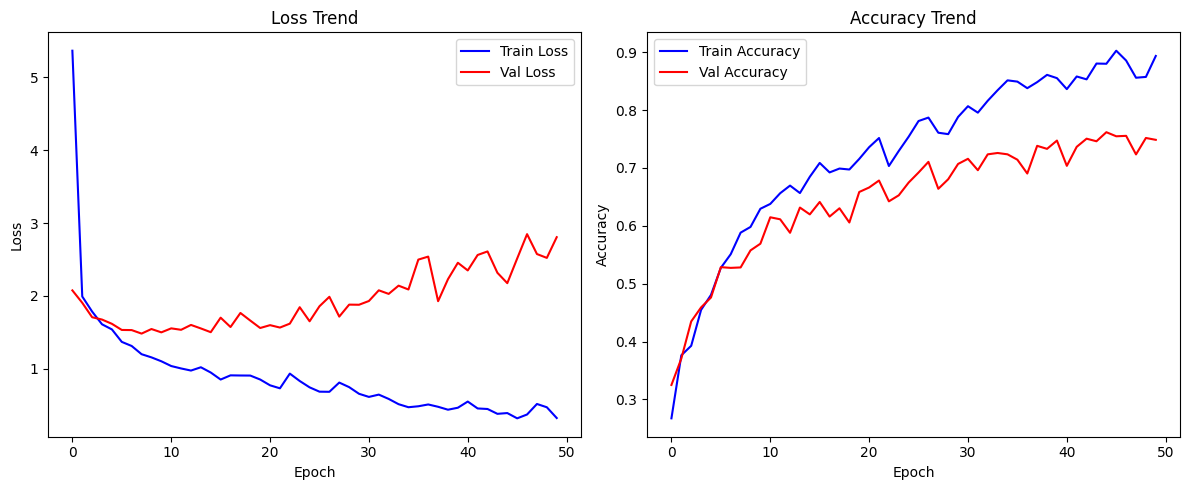

In [ ]:
train_losses_CNN = CNN_training_df["train_loss"]
val_losses_CNN = CNN_training_df["val_loss"]
train_accuracies_CNN = CNN_training_df["train_accuracy"]
val_accuracies_CNN = CNN_training_df["val_accuracy"]

# Plot the training results
plot_training_results(len(CNN_training_df), train_losses_CNN, val_losses_CNN, train_accuracies_CNN, val_accuracies_CNN)

# Resources

[PyTorch for Audio + Music Processing](https://www.youtube.com/watch?v=gp2wZqDoJ1Y&list=PL-wATfeyAMNoirN4idjev6aRu8ISZYVWm) by Valerio Velardo

* 1d conv for sign
* Trainer pytorch lightening
* Claude usage
* occhio ai parametri in output sul segnale, mel_spec ...
* Araujo paper